In [1]:
#import libraries
import torch                                   # Core PyTorch library (for tensors, GPU ops, autograd, etc.)
import torchvision                             # Computer vision package built on PyTorch (datasets, models, transforms, utils)
import torchvision.transforms as transforms    # Image preprocessing utilities (resize, crop, normalize, etc.)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import torch.nn as nn                          # Neural network module in PyTorch (contains layers like Linear, Conv2d, etc.)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# # Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Available device: ', device)

Available device:  cuda


# 1) Loading Cifar-10 dataset from drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# List all files in "MyDrive"
import os
print(os.listdir('/content/drive/MyDrive/CIFAR-10/'))   # Print all files in CIFAR-10 folder made on my drive


# Extracting zip file in CIFAR-10 folder:
import zipfile

zip_path = "/content/drive/MyDrive/CIFAR-10/zip folder/train.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:             # Opens the ZIP file (train.zip) in read mode ('r'). zip_ref is a ZipFile object that allows access to the contents.
    zip_ref.extractall("/content/")                     # Extracts the ZIP file's contents to /content/, which is Google Colab's temporary storage. After extraction, the images
                                                            # will be inside /content/train/ if the ZIP contained a train/ folder.

# New file location according to colab
training_images_path = "/content/train"
label_path = "/content/drive/MyDrive/CIFAR-10/trainLabels.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['trainLabels.csv', 'zip folder', 'Indigo_Airplane.jpg', 'A_chital_stag.jpg', 'bird.jpg', 'Fallow Deer.jpg']


## 1.1) Viewing Labels of the dataset

In [4]:
label_df = pd.read_csv(label_path)

print('Shape of the dataset: ', label_df.shape)
label_df.head()

Shape of the dataset:  (50000, 2)


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


## 1.2) Viewing images from the dataset

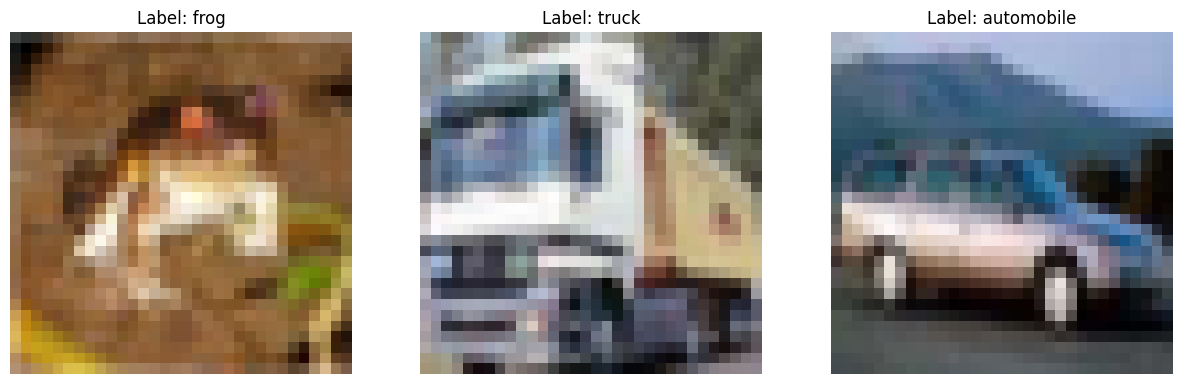

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (15, 10))


# 1st image
img_path = training_images_path + str('/1.png')                 #'/content/train/1.png'
img_label = label_df['label'][0]

img = mpimg.imread(img_path)
axes[0].imshow(img)
axes[0].set_title(f'Label: {img_label}')
axes[0].axis("off")

# 2nd image
img_path = training_images_path + str('/2.png')
img_label = label_df['label'][1]

img = mpimg.imread(img_path)
axes[1].imshow(img)
axes[1].set_title(f'Label: {img_label}')
axes[1].axis("off")

# 3rd image
img_path = training_images_path + str('/5.png')
img_label = label_df['label'][4]

img = mpimg.imread(img_path)
axes[2].imshow(img)
axes[2].set_title(f'Label: {img_label}')
axes[2].axis("off")

plt.show()

In [6]:
print('Shape of 1 image: ', img.shape)

Shape of 1 image:  (32, 32, 3)


# 2) Creating Dataset class

In [7]:
class MyDataset(Dataset):

  def __init__(self, features, label, transform = None):

    self.features = features
    self.label = label
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, ind):

    x = self.features[ind]
    y = self.label[ind]

    if self.transform:
      x, y = self.transform(x, y)

    return x, y

# 3) Creating transformation function

In [8]:
def transformation(features, label):

  # Feature transformation
  features = features/255.0
  features = torch.tensor(features, dtype = torch.float32)

  # Encoding labels, then converting them from numpy-array to tensors
  label_dic = {'airplane' : 0, 'automobile' : 1, 'bird' : 2, 'cat' : 3, 'deer' : 4, 'dog' : 5, 'frog' : 6, 'horse' : 7, 'ship' : 8, 'truck' : 9}

  val = label_dic[label]

  labels = torch.tensor(val, dtype = torch.long)


  return features, labels

# 4) Splitting data into training & testing

## 4.1) Converting images into numpy array

In [9]:
img_folder_path = '/content/train/'

cifar10_data = []                                       # A list to store all images in numpy array format


for i in range(label_df.shape[0]):
  img_path = img_folder_path + str(i+1) + '.png'        # Path of the image
  img = mpimg.imread(img_path)                          # Reading image in numpy array format
  cifar10_data.append(img)                              # Storing numpy arrays in the list


print('Shape of image dataset: ', len(cifar10_data))
print('Datatype of cifar10_data: ', type(cifar10_data))
print('Datatype of elements(images) stored: ', type(cifar10_data[0]))

Shape of image dataset:  50000
Datatype of cifar10_data:  <class 'list'>
Datatype of elements(images) stored:  <class 'numpy.ndarray'>


In [10]:
# Creating features and label of the dataset in numpy array format

x = np.array(cifar10_data)
y = np.array(label_df['label'])

print('Type of image dataset: ', type(x), 'and of label: ', type(y))
print('Shape of image dataset: ', x.shape, 'and of label: ', y.shape)

Type of image dataset:  <class 'numpy.ndarray'> and of label:  <class 'numpy.ndarray'>
Shape of image dataset:  (50000, 32, 32, 3) and of label:  (50000,)


## 4.2) Train Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print('Shape of train data: ', x_train.shape, y_train.shape)
print('Shape of test data: ', x_test.shape, y_test.shape)

Shape of train data:  (40000, 32, 32, 3) (40000,)
Shape of test data:  (10000, 32, 32, 3) (10000,)


# 5) Creating Dataset and DataLoader objects

In [12]:
train_data = MyDataset(x_train, y_train, transform = transformation)
test_data = MyDataset(x_test, y_test, transform = transformation)

train_loader = DataLoader(train_data, batch_size = 64, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False, pin_memory = True)

In [13]:
# Checking how 1 image data looks
img, label = next(iter(train_data))
print(img.shape)
print('Label value for this image: ', label, '. And its shape is: ', label.shape)

torch.Size([32, 32, 3])
Label value for this image:  tensor(6) . And its shape is:  torch.Size([])


In [14]:
# Checking how 1 batch of data looks
for img, lab in train_loader:
  print(img.shape)
  print(lab.shape)
  break

torch.Size([64, 32, 32, 3])
torch.Size([64])


# 6) Patch Embedding

CIFAR-10 images are 32×32×3.
Lets take patch_size = 8, then:

- num_patches = (32/8) * (32/8) = 16

- Each patch is flattened and projected into a vector of size embed_dim (say 192).

Output shape → [B, 16, 192].

In [15]:
patch_size = 8
embed_dim = 192
num_patches = int((32/patch_size) * (32/patch_size))

In [16]:
class PatchEmbedding(nn.Module):

  def __init__(self):
    super(PatchEmbedding, self).__init__()

    self.patch_emd = nn.Conv2d(in_channels = 3, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size)


  def forward(self, x):
    x = x.permute(0, 3, 1, 2)                # PyTorch expects input to be (Batch Size, Channels, Height, Width), not (Batch Size, Height, Width, Channels)
    x = self.patch_emd(x)                    # [B, embed_dim, H/patch, W/patch]
    x = x.flatten(start_dim = 2, end_dim = 3) # [B, embed_dim, num_patches]
    x = x.permute(0, 2, 1)                   # [B, num_patches, embed_dim]
    return x

#### 🔍 Understanding Patch Embedding in ViT Using Convolution

The original **Vision Transformer (ViT)** paper defines the patch embedding process as:

1. **Split the input image into fixed-size patches**  
2. **Flatten each patch into a vector**  
3. **Linearly project each vector to the embedding dimension**  
4. **Prepend a `[CLS]` token** for classification  

---
**Conv2d trick**

- Each Conv2d filter has weights of size [in_channels, patch_size, patch_size] = [3, 4, 4].

- That’s exactly 48 weights → the same size as one flattened patch.

- When the convolution slides over the image with stride=4, each filter sees one 4×4×3 patch.

- It computes:  `y = ∑(patch_pixels ∗ filter_weights) + bias`

- For out_channels = embed_dim, we have embed_dim different filters → each producing one number for that patch.

- So the patch [4×4×3] is projected into [embed_dim].

**That’s exactly the same as: Flatten patch → Linear layer (48 → embed_dim).**

---

**🔁 Summary Table**

| ViT Paper Step | Conv2D Equivalent |
|---------------|-------------------|
| Split image into patches | `kernel_size = patch_size`, `stride = patch_size` |
| Flatten each patch | Done implicitly inside convolution |
| Linear projection | `out_channels = embed_dim` |
| Patch vector length = 48 (4×4×3) | Filter weight size = 48 |

---

**✅ Key Takeaway**

> A single `Conv2d` layer with `kernel_size = patch_size`, `stride = patch_size`, and `out_channels = embed_dim` **is a complete replacement** for  
> `Flatten + Linear` patch embedding used in ViT.

---

In [17]:
for img, lab in train_loader:
  print(img.shape)
  print(lab.shape)
  break

# Transpose the image tensor to have channels first (Batch Size, Channels, Height, Width), cause this is how PyTorch expects input to be not [Batch Size, Height, Width, Channels]
img = img.permute(0, 3, 1, 2)   # .permute reorders the dimestions iderired format

patch_emd = nn.Conv2d(in_channels = 3, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size)
embed_img = patch_emd(img)
print(embed_img.shape)
print(embed_img.flatten(start_dim = 2, end_dim =3).shape)
print(embed_img.flatten(2, 3).permute(0, 2, 1).shape)

torch.Size([64, 32, 32, 3])
torch.Size([64])
torch.Size([64, 192, 4, 4])
torch.Size([64, 192, 16])
torch.Size([64, 16, 192])


# 7) Defining TransformerEncoder Architecture of ViT

After patch embedding, the sequence of embedded patches is passed through the TransformerEncoder block.  
The block follows the standard Transformer design and consists of the following components:

- **Layer Normalization (LN):**  
  Normalizes the input embeddings across the feature dimension to stabilize training.  
  This ensures that each token embedding has zero mean and unit variance before being sent into the attention layer.

- **Multi-Head Self-Attention (MHA):**  
  Allows each patch embedding to attend to all other patches in the image, capturing global context. Here we taking patch vector of dimension 192 and then we divide that into 6 attention heads, each head will have vector of dimension 32(192/6). **Note:** The embedding dimension should always be divisible by the number of attention head.                                                    
  Since we are doing *self-attention*, the same input `x` is used for Query (Q), Key (K), and Value (V), that’s why we send x three times.                 
  The output is combined with the original input using a **residual connection** for stable gradient flow.

- **Second Layer Normalization (LN):**  
  Applied before sending the embeddings into the MLP.  
  Keeps the distribution stable after the attention operation.

- **Feedforward MLP (Position-wise Feedforward Network):**  
  A small neural network applied to each token independently.  
  It first expands the embedding dimension (192 → 768), applies a non-linearity (GELU), and then projects it back (768 → 192).  
  A residual connection is again added to preserve information and ease optimization.

Overall, the TransformerEncoder block follows this flow:


In [18]:
class TransformerEncoder(nn.Module):

  def __init__(self):
    super(TransformerEncoder, self).__init__()

    self.layer_norm1 = nn.LayerNorm(normalized_shape = 192)
    self.multi_head_attention = nn.MultiheadAttention(embed_dim = 192, num_heads = 6, batch_first = True)
    self.layer_norm2 = nn.LayerNorm(normalized_shape = 192)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = 192, out_features = 768),
        nn.GELU(),
        nn.Linear(in_features = 768, out_features = 192)
    )

  def forward(self, x):

    residual1 = x
    x = self.layer_norm1(x)
    x, _ = self.multi_head_attention(x, x, x)
    x = x + residual1

    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = x + residual2

    return x

# 8) Defining the MLP Head for Classification

After the Transformer Encoder processes the sequence of patch embeddings, we obtain an output of shape:  
`[Batch Size, (Number of Patches + 1), Embedding Dimension]`  

Here, the **first token** corresponds to the special **[CLS] token**, which acts as a representation of the entire image.  
The MLP Head is responsible for converting this representation into class logits for prediction.  

The MLP Head consists of:
- **Layer Normalization:**  
  Applied to the CLS token embedding to stabilize and improve training.  
- **Linear Layer:**  
  Maps the embedding dimension (192) down to the number of classes (10 for CIFAR-10).  

Final   operation:                                                                      CLS token (192-dim) → LayerNorm → Linear → Class logits (10-dim)


In [19]:
class MLPhead(nn.Module):

  def __init__(self):
    super(MLPhead, self).__init__()

    self.MLP = nn.Sequential(
        nn.LayerNorm(normalized_shape = 192),                          # Adding layer norm for stability
        nn.Linear(in_features = 192, out_features = 10)
    )

  def forward(self, x):
    cls_token = x[:, 0]                                            # Taking CLS token from each sample in batch: [B, 192]
    cls_token = self.MLP(cls_token)
    return cls_token

# 9) Defining Vision Transformer

In [20]:
class VisionTransformer(nn.Module):

  def __init__(self):
    super(VisionTransformer, self).__init__()

    self.patch_embedding = PatchEmbedding()
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))            # Creating 1 cls_token for each sample in the batch
    self.pos_encoding = nn.Parameter(torch.rand(1, num_patches + 1, embed_dim))      # Creating 1 posistion vector for each patch vector (and 1 cls token: num_patches + 1)
    self.transformer_blocks = nn.Sequential(
        TransformerEncoder(),
        TransformerEncoder(),
        TransformerEncoder(),
        TransformerEncoder()
    )
    self.mlp_head = MLPhead()

  def forward(self, x):                     # x is input image
    batch_size = x.shape[0]

    # Patch vector
    x = self.patch_embedding(x)
    cls_tokens = self.cls_token.repeat(batch_size, 1, 1)     # This creates one CLS token for each image in the batch: [1, 1, embed_dim] → [B, 1, embed_dim].
    x = torch.cat([cls_tokens, x], 1)           # Adding CLS token to the sequence of patch embeddings: [B, num_patches, embed_dim] → [B, num_patches+1, embed_dim].

    # Positional encoded vectors
    x = x + self.pos_encoding

    # TransformerEncoder block
    x = self.transformer_blocks(x)

    # MLP head
    x = self.mlp_head(x)

    return x

# 10) Training ViT on the data

## 10.1) Creating the model

In [21]:
model = VisionTransformer()

# moving model to GPU
model = model.to(device)

## 10.2) Defining Optimizer & Loss function for the model

In [22]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Loss Function
loss_fn = nn.CrossEntropyLoss()

## 10.3) Creating Early stooping for the model

In [23]:
class EarlyStopping:

  def __init__(self):

    self.patience = 5              # Number of epochs to wait before stopping if no improvement
    self.delta = 0.1               # Minimum change in validation accuracy required to consider it an improvement, here 0.5
    self.path = 'best_model.pth'   # File path where the best model will be saved
    self.counter = 0               # Counter to keep track of how many epochs have passed with no improvement
    self.early_stop = False        # Flag that will become True if training should stop
    self.best_acc = None           # Best validation accuracy seen so far

  def __call__(self, val_acc, model):

    if self.best_acc is None:                       # For the 1st epoch
      self.best_acc = val_acc
      self.save_checkpoint(val_acc, model)

    elif val_acc < self.best_acc + self.delta:      # If the new accuracy is NOT better than (best_acc + delta), treat it as "no improvement"
      self.counter += 1
      if self.counter >= self.patience:             # If counter reaches patience limit → stop training
        print('Early stopping triggered')
        self.early_stop = True

    else:                                           # If validation accuracy improved (greater than best_acc + delta)
      self.save_checkpoint(val_acc, model)
      self.counter = 0


  def save_checkpoint(self, val_acc, model):        # Saves the current model to disk
    print(f'Validation accuracy increased ({self.best_acc:.6f} --> {val_acc:.6f}). Model saved.')
    torch.save(model.state_dict(), self.path)
    self.best_acc = val_acc

## 10.4) Training the model

In [24]:
train_acc_list = []   # store training accuracies per epoch
val_acc_list = []     # store validation accuracies per epoch
es = EarlyStopping()  # Early stopping object

for epoch in range(200):
  epoch_accuracy = 0
  total_correct_pred = 0
  total_pred = 0

  model.train()                                              # Sets model into training mode
  for images, labels in train_loader:

    # Moving data to GPU
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    y_pred = model.forward(images)

    # Loss calculation
    loss = loss_fn(y_pred, labels)

    # Backward pass
    loss.backward()

    # Parameter update
    optimizer.step()

    # Reset gradients
    optimizer.zero_grad()

    # Counting number of correct prediction
    _, batch_pred = torch.max(y_pred, 1)
    batch_correct_pred = (batch_pred == labels).sum().item()
    total_correct_pred += batch_correct_pred
    total_pred += len(labels)

  epoch_accuracy = (total_correct_pred/total_pred)*100
  train_acc_list.append(epoch_accuracy)


  # Calculating Validation accuracy for this epoch
  model.eval()                                                          # Sets model into evaluation mode

  with torch.no_grad():
    val_acc = 0
    total_correct_pred = 0
    total_pred = 0

    for images, labels in test_loader:

      # Moving testing data on GPU
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      y_test_pred = model.forward(images)

      # Counting number of correct pred
      _, batch_pred = torch.max(y_test_pred, 1)
      batch_correct_pred = (batch_pred == labels).sum().item()
      total_correct_pred += batch_correct_pred
      total_pred += len(labels)

    val_acc = (total_correct_pred/total_pred)*100
    val_acc_list.append(val_acc)

  print(f"Epoch {epoch+1}:    Accuracy: {epoch_accuracy:.4f}%, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc:4f}%")

  # Applying early stopping
  es(val_acc, model)
  if es.early_stop:
    break

Epoch 1:    Accuracy: 10.6675%, Loss: 2.2138, Validation Accuracy: 14.790000%
Validation accuracy increased (14.790000 --> 14.790000). Model saved.
Epoch 2:    Accuracy: 18.4775%, Loss: 2.0229, Validation Accuracy: 21.770000%
Validation accuracy increased (14.790000 --> 21.770000). Model saved.
Epoch 3:    Accuracy: 22.2175%, Loss: 2.0460, Validation Accuracy: 24.080000%
Validation accuracy increased (21.770000 --> 24.080000). Model saved.
Epoch 4:    Accuracy: 23.8825%, Loss: 1.9496, Validation Accuracy: 25.540000%
Validation accuracy increased (24.080000 --> 25.540000). Model saved.
Epoch 5:    Accuracy: 25.0775%, Loss: 2.0324, Validation Accuracy: 25.880000%
Validation accuracy increased (25.540000 --> 25.880000). Model saved.
Epoch 6:    Accuracy: 25.9100%, Loss: 2.0230, Validation Accuracy: 25.120000%
Epoch 7:    Accuracy: 27.4725%, Loss: 2.1205, Validation Accuracy: 29.060000%
Validation accuracy increased (25.880000 --> 29.060000). Model saved.
Epoch 8:    Accuracy: 29.5300%, Lo

# 11) Model Evaluation

In [25]:
# Setting model to evaluation mode
model = model.eval()

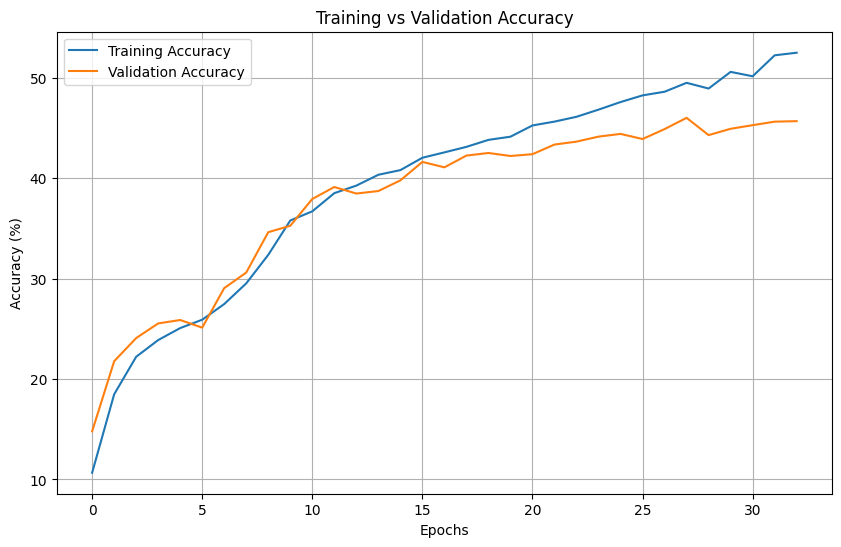

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 12) Model prediction on new data sample

In [28]:
import cv2
label_dic = {'airplane' : 0, 'automobile' : 1, 'bird' : 2, 'cat' : 3, 'deer' : 4, 'dog' : 5, 'frog' : 6, 'horse' : 7, 'ship' : 8, 'truck' : 9}

Raw probabilities:  tensor([[ 5.6134, -0.7476,  1.7322,  0.8472, -2.6204, -3.6737, -2.4322, -0.9533,
         -1.8313,  3.1604]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted class index:  0
The predicted class is:  airplane


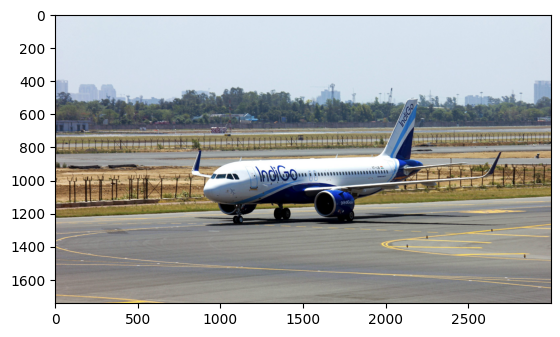

In [29]:
# Read image
img = mpimg.imread('/content/drive/MyDrive/CIFAR-10/Indigo_Airplane.jpg')
plt.imshow(img)

# Resize image to model input size
img = cv2.resize(img, (32, 32))

# Adding batch dimension in the nd-array
img = np.expand_dims(img, axis = 0)

# Converting nd-array to tensor
img = torch.tensor(img, dtype = torch.float32)

# Moving image to GPU
img = img.to(device)

# Predicting the result
img_pred = model.forward(img)
print('Raw probabilities: ', img_pred)

# Getting the predicted class
_, pred_idx = torch.max(img_pred, 1)
pred_idx = pred_idx.item()                              # convert tensor to plain int
print('Predicted class index: ', pred_idx)

# Reverse dictionary: index → label
idx_to_label = {v: k for k, v in label_dic.items()}
print('The predicted class is: ', idx_to_label[pred_idx])

Raw probabilities:  tensor([[ 6.4318, -1.3062,  1.5360,  0.8909, -3.0405, -2.6990, -1.3906, -2.1818,
         -1.3242,  1.8108]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted class index:  0
The predicted class is:  airplane


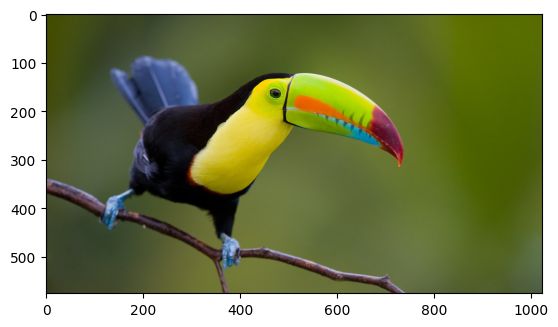

In [30]:
# Read image
img = mpimg.imread('/content/drive/MyDrive/CIFAR-10/bird.jpg')
plt.imshow(img)

# Resize image to model input size
img = cv2.resize(img, (32, 32))

# Adding batch dimension in the nd-array
img = np.expand_dims(img, axis = 0)

# Converting nd-array to tensor
img = torch.tensor(img, dtype = torch.float32)

# Moving image to GPU
img = img.to(device)

# Predicting the result
img_pred = model.forward(img)
print('Raw probabilities: ', img_pred)

# Getting the predicted class
_, pred_idx = torch.max(img_pred, 1)
pred_idx = pred_idx.item()                              # convert tensor to plain int
print('Predicted class index: ', pred_idx)

# Reverse dictionary: index → label
idx_to_label = {v: k for k, v in label_dic.items()}
print('The predicted class is: ', idx_to_label[pred_idx])

Raw probabilities:  tensor([[ 4.8272, -0.9784, -1.0267,  1.1873, -1.8654, -2.1278,  1.6043, -4.7741,
         -0.5283,  2.0037]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted class index:  0
The predicted class is:  airplane


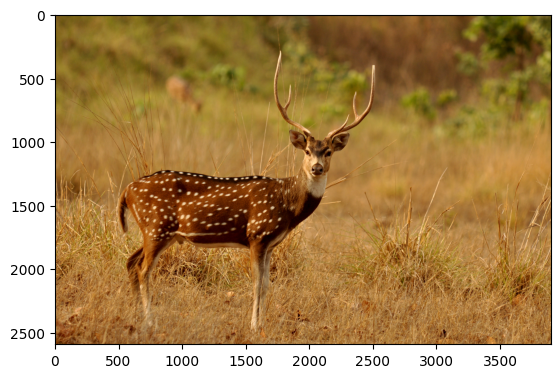

In [31]:
# Read image
img = mpimg.imread('/content/drive/MyDrive/CIFAR-10/A_chital_stag.jpg')
plt.imshow(img)

# Resize image to model input size
img = cv2.resize(img, (32, 32))

# Adding batch dimension in the nd-array
img = np.expand_dims(img, axis = 0)

# Converting nd-array to tensor
img = torch.tensor(img, dtype = torch.float32)

# Moving image to GPU
img = img.to(device)

# Predicting the result
img_pred = model.forward(img)
print('Raw probabilities: ', img_pred)

# Getting the predicted class
_, pred_idx = torch.max(img_pred, 1)
pred_idx = pred_idx.item()                              # convert tensor to plain int
print('Predicted class index: ', pred_idx)

# Reverse dictionary: index → label
idx_to_label = {v: k for k, v in label_dic.items()}
print('The predicted class is: ', idx_to_label[pred_idx])

Raw probabilities:  tensor([[ 6.1562, -0.5007,  0.7244,  0.9995, -2.9050, -3.8514, -1.4214, -2.9615,
         -0.4297,  2.6747]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted class index:  0
The predicted class is:  airplane


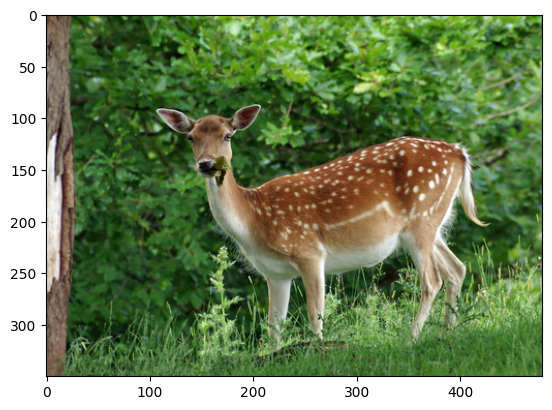

In [32]:
# Read image
img = mpimg.imread('/content/drive/MyDrive/CIFAR-10/Fallow Deer.jpg')
plt.imshow(img)

# Resize image to model input size
img = cv2.resize(img, (32, 32))

# Adding batch dimension in the nd-array
img = np.expand_dims(img, axis = 0)

# Converting nd-array to tensor
img = torch.tensor(img, dtype = torch.float32)

# Moving image to GPU
img = img.to(device)

# Predicting the result
img_pred = model.forward(img)
print('Raw probabilities: ', img_pred)

# Getting the predicted class
_, pred_idx = torch.max(img_pred, 1)
pred_idx = pred_idx.item()                              # convert tensor to plain int
print('Predicted class index: ', pred_idx)

# Reverse dictionary: index → label
idx_to_label = {v: k for k, v in label_dic.items()}
print('The predicted class is: ', idx_to_label[pred_idx])